In [ ]:
"""
Created on Mon Jan  8 2020

@author: Or Duek
Check Aging data timeseries
"""

# Aging timeseries analysis
# Using the connUtils.py file


In [4]:
import os
import pandas as pd
from nilearn import plotting
import numpy as np
import matplotlib.pyplot as plt
import scipy
import nilearn

In [2]:
## two regions that were found comparing cs+ to cs- in the second part of the experiment. 
## lower activation here = (-3, 21, -12) MNI space
## higher activation here = (3, 28, 22)

/media/Data/RCF_BidsConversion


In [ ]:
# here we load the atlas - this is the Yeo one, but we can use others
#atlas_filename = '/home/or/Downloads/1000subjects_reference_Yeo/Yeo_JNeurophysiol11_SplitLabels/MNI152/Yeo2011_17Networks_N1000.split_components.FSL_MNI152_1mm.nii.gz'
#atlas_labes = pd.read_csv('/home/or/Downloads/1000subjects_reference_Yeo/Yeo_JNeurophysiol11_SplitLabels/Yeo2011_17networks_N1000.split_components.glossary.csv')
#coords = coords = plotting.find_parcellation_cut_coords(labels_img=atlas_filename)
# take one subjects file 

In [2]:
# use aal atlas

aal_atlas = nilearn.datasets.fetch_atlas_aal(version='SPM12', data_dir=None, url=None, resume=True, verbose=1)


In [3]:
atlas_filename = aal_atlas.maps
atlas_labels = aal_atlas.labels

In [4]:
atlas_labels
#atlas_labels.index('Occipital_Sup_R')
atlas_labels.index('Olfactory_L')

20

In [166]:
# put functional file, confound file and event file here - this is for one subject
sub = '1206'
func_file = '/media/Data/RCF_output/fmriprep/sub-%s/ses-1/func/sub-%s_ses-1_task-task509_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz' %(sub, sub)
confound_file = '/media/Data/RCF_output/fmriprep/sub-%s/ses-1/func/sub-%s_ses-1_task-task509_desc-confounds_regressors.tsv'%(sub, sub)
events_file = '/media/Data/RCF/RCF_BidsConversion/events.csv'

In [167]:
# read event file for specific subject
subject = int(sub)
events = pd.read_csv(events_file)
eventSub = events[events.Subject==subject]
eventSub[eventSub.trial_type=="CSAplus"]

,Subject,trial_type,onset,duration
2299,1206,CSAplus,44,6
2304,1206,CSAplus,104,6
2310,1206,CSAplus,176,6
2316,1206,CSAplus,250,6
2317,1206,CSAplus,260,6
2324,1206,CSAplus,346,6
2327,1206,CSAplus,380,6
2333,1206,CSAplus,456,6
2335,1206,CSAplus,482,6


In [168]:
# create timeseries of all ROIs in atlas
#timeSer= timeSeriesSingle(func_file, confound_file, atlas_filename)
def removeVars (confoundFile):
    # this method takes the csv regressors file (from fmriPrep) and chooses a few to confound. You can change those few
    import pandas as pd
    confound = pd.read_csv(confoundFile,sep="\t", na_values="n/a")
    finalConf = confound[['csf','white_matter','global_signal', 'framewise_displacement', 'dvars', 'std_dvars',
                          'trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z',
                        ]] # can add 'global_signal' also ,
     # change NaN of FD to zero
    finalConf = np.array(finalConf.fillna(0.0))
    #finalConf[0,2] = 0 # if removing FD than should remove this one also
    return finalConf
from nilearn.input_data import NiftiLabelsMasker
    # define masker here

# setting based on high activity in 4th contrast
masker = nilearn.input_data.NiftiSpheresMasker([(3, 28, 22)], radius=4, standardize=True,
                                               detrend=True, high_pass=0.01, t_r=1, verbose=5)
#masker = NiftiLabelsMasker(labels_img=atlas_filename, standardize=True, detrend = True, smoothing_fwhm = 8,
 #                          memory='nilearn_cache', verbose=5, high_pass = 0.01, t_r = 1.)

In [169]:
tc = masker.fit_transform(func_file, confounds=removeVars(confound_file))
tc.shape
# 116 regions in aal atlas

[NiftiSpheresMasker.transform_single_imgs] Loading data from /media/Data/RCF_output/fmriprep/sub-1206/ses-1/func/sub-1206_ses-1_task-task509_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiSpheresMasker.transform_single_imgs] Extracting region signals
[NiftiSpheresMasker.transform_single_imgs] Cleaning extracted signals


(509, 1)

In [161]:
def onsetDuration(onsets, duration, timeseries):
# this function receives array of onsets and duration of the same trial type and retures timeseries of this trialtype
    addDur = 5 # addint number of TRs to get the HRF
    beforeOnset = 4 # how many TRs before onset, to see full HRF
    newlist = []
    for onset in onsets:
    
        newlist.append(timeseries[onset-beforeOnset:onset+duration+addDur,:]) 
    return newlist

In [170]:
conditions=list(set(eventSub.trial_type.values))


onset_csAplus = eventSub.onset[eventSub.trial_type==conditions[conditions.index('CSAplus')]]
onset_csAplusUS = eventSub.onset[eventSub.trial_type==conditions[conditions.index('CSAplusUS')]]
onset_csMinus = eventSub.onset[eventSub.trial_type==conditions[conditions.index('CSminus')]]
duration = 6

g = onsetDuration(onset_csAplus, duration, tc)
f = onsetDuration(onset_csAplusUS, duration, tc)
minus = onsetDuration(onset_csMinus, duration, tc)
np.array(g).shape


(9, 15, 1)

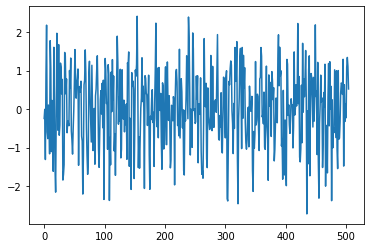

In [19]:
%matplotlib inline
plt.plot(tc)

In [25]:
conditions

['CSAplus', 'CSAplusUS', 'CSminus', 'CSBplus', 'CSBplusUS']

In [163]:
def averaging_response(taskType_array):
    # this function receives taskType array and return averaged response
    average = np.mean(taskType_array, axis = 0)
    return np.array(average)

/home/or/miniconda3/envs/neuroAnalysis/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Support for passing a (n, 1)-shaped error array to errorbar() is deprecated since Matplotlib 3.1 and will be removed in 3.3; pass a 1D array instead.
  if sys.path[0] == '':
/home/or/miniconda3/envs/neuroAnalysis/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Support for passing a (n, 1)-shaped error array to errorbar() is deprecated since Matplotlib 3.1 and will be removed in 3.3; pass a 1D array instead.
  del sys.path[0]
/home/or/miniconda3/envs/neuroAnalysis/lib/python3.7/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Support for passing a (n, 1)-shaped error array to errorbar() is deprecated since Matplotlib 3.1 and will be removed in 3.3; pass a 1D array instead.
  


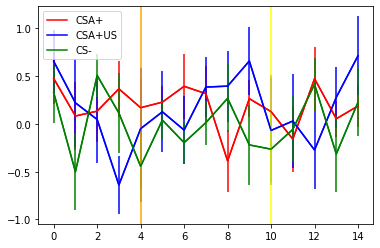

In [171]:
#region = 
csAplus_cond = averaging_response(g)
csAplusUS_cond = averaging_response(f)
csMinus_cond = averaging_response(minus)
csAplus_std = scipy.stats.sem(np.array(g), axis=0)
csAplusUS_std = scipy.stats.sem(np.array(f), axis=0)
csMinus_std = scipy.stats.sem(np.array(minus), axis=0)
%matplotlib inline
plt.plot(csAplus_cond, color='red', label = "CSA+")
plt.plot(csAplusUS_cond, color='blue', label = "CSA+US")
plt.plot(csMinus_cond, color='green', label = "CS-")
plt.errorbar(range(0,len(csAplus_cond)),csAplus_cond, yerr=csAplus_std, color = 'red')
plt.errorbar(range(0,len(csAplusUS_cond)),csAplusUS_cond, yerr=csAplusUS_std, color = 'blue')
plt.errorbar(range(0,len(csMinus_cond)),csMinus_cond, yerr=csMinus_std, color = 'green')
## add lines
plt.axvline(4, color="orange")
plt.axvline(10, color = "yellow")
plt.legend(loc = "upper left")
#plt.axvline(5.5+6, color = "yellow")


## Convulve the task time course with HRF function

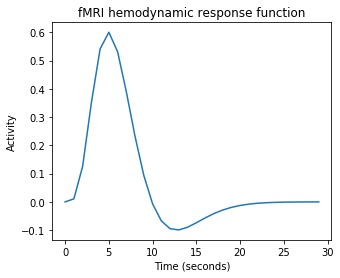

In [177]:
from scipy.stats import gamma
def hrf(times,peakscale=0.6,peaktime=6,undershoottime=12,undershootratio=.35):
    """ Return values for HRF at given times """
    # Gamma pdf for the peak
    peak_values = gamma.pdf(times, peaktime)
    # Gamma pdf for the undershoot
    undershoot_values = gamma.pdf(times, undershoottime)
    # Combine them
    values = peak_values - undershootratio * undershoot_values
    # Scale max to 0.6
    return values / np.max(values) * peakscale

simsample_rate=1 #Every 1 second
simsample_times = np.arange(0, 30, simsample_rate)
hrf_at_simsample = hrf(simsample_times,0.6,6,12,.35)

plt.figure(figsize=(5,4))
plt.title('fMRI hemodynamic response function')
plt.xlabel("Time (seconds)")
plt.ylabel("Activity")
plt.plot(simsample_times, hrf_at_simsample,label='Normal HRF')

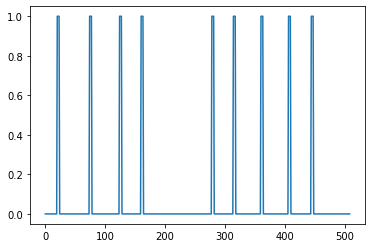

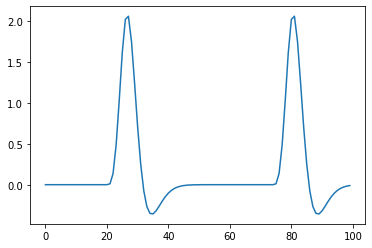

In [178]:
onset_csAplus = eventSub.onset[eventSub.trial_type==conditions[conditions.index('CSAplus')]]
onset_csAplusUS = eventSub.onset[eventSub.trial_type==conditions[conditions.index('CSAplusUS')]]
onset_csMinus = eventSub.onset[eventSub.trial_type==conditions[conditions.index('CSminus')]]
timeSer = np.zeros(tc.shape[0])
for i in onset_csMinus:
    timeSer[i:i+4] = 1
timeSer
timeConv = np.convolve(timeSer, hrf_at_simsample)
plt.plot(timeSer)
plt.show()
plt.plot(timeConv[0:100])

(0.02218077478909216, 0.6207436286411625)


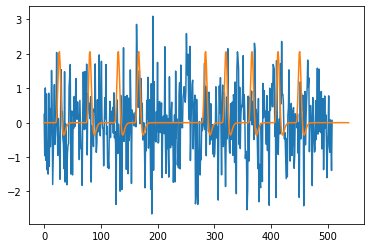

In [180]:
print(scipy.stats.pearsonr(tc[9:,0],timeConv[9:509]))
plt.plot(tc[:,0])
plt.plot(timeConv)

(-0.22679761660470976, 2.3191202311354034e-07)


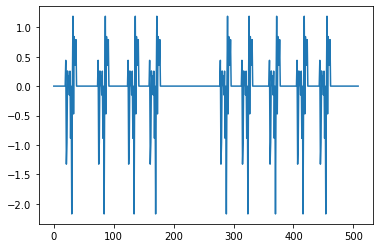

In [181]:
timeG = np.zeros(tc.shape[0])
for i in onset_csMinus:
    for a in minus:
        timeG[i:i+18] = a[:,0]
    
plt.plot(timeG)
print(scipy.stats.pearsonr(timeG,timeConv[0:timeG.shape[0]]))

In [158]:
timeConv.shape

(534,)